In [1]:
# For Environment
import gym

# For Environment Warppers
from openai_wrappers.atari_wrappers import make_atari,wrap_deepmind, wrap_pytorch, MaxAndSkipEnv, FireResetEnv

# For Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.functional as F

# For replay buffer
from collections import deque
import random

# For common use
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Environment 'Atari'

In [2]:
env_name = 'BreakoutNoFrameskip-v4'
env = gym.make(env_name)
state = env.reset()
next_state, reward, done, _ = env.step(action = 0)

Num of Actions :  4
Action meaning :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
State Size :  (210, 160, 3)
State Example


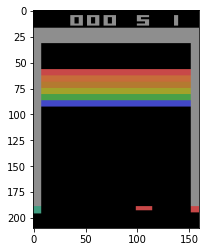

In [3]:
print('Num of Actions : ' , env.action_space.n)
print('Action meaning : ' , env.unwrapped.get_action_meanings())
print('State Size : ', np.shape(state))
print('State Example')
plt.imshow(state)

## OpenAI Gym Wrappers
<img src = './img/1.png'>

In [4]:
env = make_atari(env_name)
env = wrap_deepmind(env, frame_stack=True)
env = wrap_pytorch(env)

state = env.reset()
next_state, reward, done, _ = env.step(action = 0)

Num of Actions :  4
Action meaning :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
State Size :  (4, 84, 84)
State Example


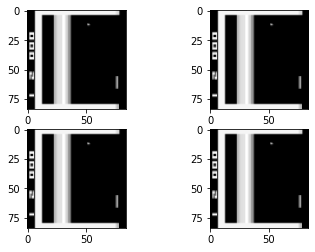

In [5]:
print('Num of Actions : ' , env.action_space.n)
print('Action meaning : ' , env.unwrapped.get_action_meanings())
print('State Size : ', np.shape(state))
print('State Example')
# plt.subplots(2,2)
for i in range(4): 
    plt.subplot(2,2,i+1)
    plt.imshow(state[i,:,:], cmap='gray')

## Replay Buffer

In [6]:
class ReplayBuffer():
    def __init__(self, buffer_size=100000):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen = self.buffer_size)

    def put(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(torch.stack, zip(*batch))
        return torch.squeeze(state), action, reward, torch.squeeze(next_state), done

## Agent

In [17]:
class Atari_Agent:
    def __init__(self, input_shape, num_action, save_dir):
        self.input_shape = input_shape
        self.num_action = num_action
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        self.net = DQN_atari(self.input_shape, self.num_action)
        if self.use_cuda:
            self.net = self.net.to(device = 'cuda')

        self.step = 0

        # Replay Buffer
        self.buffer = ReplayBuffer(buffer_size= 100000)
        self.batch_size = 32

        # Explore
        self.eps = 1
        self.eps_decay = 0.99999975
        self.eps_min = 0.05

        self.save_interval = 5e5

        # TD-Error
        self.gamma = 0.9

        # Learn
        self.optimizer = optim.Adam(self.net.parameters(), lr = 0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()
        self.sync_target_net_interval = 1e4
        self.learn_interval = 3
        self.learn_start = 100 #1e4

    def act(self, state):
        if np.random.rand() < self.eps:
            # Exploitation
            action = np.random.randint(self.num_action)
        else:
            # Eploration
            if self.use_cuda:
                state = torch.tensor(state, dtype = torch.float32).to(device = 'cuda')
            else:
                state = torch.tensor(state, dtype = torch.float32)
            
            state = state.unsqueeze(0)
            action_values = self.net.forward(state, model = 'online')
            action = torch.argmax(action_values, axis=1).item()

        # Eps decay
        self.eps *= self.eps_decay
        self.eps = max(self.eps, self.eps_min)

        self.step += 1

        return action
        
    def memory_save(self, state, action, reward, next_state, done):
        state = np.expand_dims(state,0)
        next_state = np.expand_dims(next_state,0)
        if self.use_cuda:
            state = torch.tensor(state, dtype = torch.float32).to(device = 'cuda')
            action = torch.tensor(action).to(device = 'cuda')
            reward = torch.tensor(reward).to(device = 'cuda')
            next_state = torch.tensor(next_state, dtype = torch.float32).to(device = 'cuda')
            done = torch.tensor(done, dtype = torch.bool).to(device = 'cuda')
        else:
            state = torch.tensor(state, dtype = torch.float32)
            action = torch.tensor(action)
            reward = torch.tensor(reward)
            next_state = torch.tensor(next_state, dtype = torch.float32)
            done = torch.tensor(done, dtype = torch.bool)

        self.buffer.put(state, action, reward, next_state, done)

    def memory_recall(self):
        return self.buffer.sample(self.batch_size)


    def td_estimate(self, state, action):
        current_q = self.net.forward(state, model = 'online')[np.arange(0, self.batch_size), action]
        return current_q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_q = self.net.forward(next_state, model = 'online')
        best_action = torch.argmax(next_state_q, axis = 1)

        next_q = self.net.forward(next_state, model = 'target')[np.arange(0, self.batch_size), best_action]

        q_star = (reward + (1 - done.float()) * self.gamma * next_q).float()
        return q_star


    def update_Q(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def sync_target_net(self):
        self.net.dqn_target_net.load_state_dict(self.net.dqn_online_net.state_dict())


    def learn(self):
        if self.step % self.sync_target_net_interval == 0:
            self.sync_target_net()

        if self.step % self.save_interval == 0:
            self.save()

        if self.step < self.learn_start:
            return None, None

        if self.step % self.learn_interval !=0:
            return None, None

        # Random Sampling from Replay Buffer
        state, action, reward, next_state, done = self.memory_recall()

        # TD estimate
        td_estimate_val = self.td_estimate(state, action)

        # TD target 
        td_target_val = self.td_target(reward, next_state, done)

        # Update Q
        loss = self.update_Q(td_estimate_val, td_target_val)

        return (td_estimate_val.mean().item(), loss)


    # def save_model(self):
    #     torch.save()



    


    

In [18]:
class DQN_atari(nn.Module):
    def __init__(self, input_shape, num_action):
        super(DQN_atari, self).__init__()
        self.input_shape = input_shape
        c, h, w = self.input_shape
        self.num_action = num_action

        self.dqn_online_net = nn.Sequential(
            nn.Conv2d(in_channels = c, out_channels = 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_action)
        )

        self.dqn_target_net = copy.deepcopy(self.dqn_online_net)

        for param in self.dqn_target_net.parameters():
            param.requires_grad = False

    def forward(self, input, model):
        if model == 'online':
            return self.dqn_online_net(input)
        elif model == 'target':
            return self.dqn_target_net(input)


In [20]:
state=env.reset()
agent = Atari_Agent(np.shape(state),env.action_space.n,'./')
buffer_size = 1000
buffer = ReplayBuffer(buffer_size)
state = env.reset()
for i in range(100000):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    agent.memory_save(state, action, reward, next_state, done)

    q, loss = agent.learn()

    state = next_state

    print(loss)
state, action, reward, next_state, done = agent.memory_recall()

0460327373003e-06
None
None
1.9155650079483166e-06
None
None
2.9269547212606994e-06
None
None
1.7743957414495526e-06
None
None
1.7950998199012247e-07
None
None
6.167889523567283e-07
None
None
1.6275896541628754e-06
None
None
1.8647999695531325e-06
None
None
8.597546639066422e-07
None
None
7.232556527014822e-07
None
None
1.6847105825945619e-06
None
None
4.412242162743496e-07
None
None
5.082061989014619e-07
None
None
2.089532017635065e-06
None
None
2.062769226540695e-06
None
None
5.991307716612937e-07
None
None
1.0822235907426148e-07
None
None
3.316426955279894e-07
None
None
2.6757491013995605e-06
None
None
1.700545908533968e-06
None
None
1.7629447029321454e-05
None
None
0.0009352243505418301
None
None
4.632958734873682e-06
None
None
1.4701965483254753e-05
None
None
1.6583728211116977e-05
None
None
4.759755938721355e-06
None
None
1.6540510614504456e-06
None
None
1.852402533586428e-06
None
None
4.397226348373806e-06
None
None
6.4701935116318054e-06
None
None
2.208656951552257e-05
None
Non

KeyboardInterrupt: 

In [10]:
agent.net.forward(state, model = 'online')[np.arange(0,32), action]

tensor([-4.2412e-02, -3.8463e-01, -1.1485e+00, -7.0742e-02,  8.2725e-03,
        -7.0675e-02, -8.1227e-02, -5.7952e-02, -1.1467e+00, -1.1489e+00,
        -1.1296e+00, -2.6564e-02, -5.5799e-02, -1.1906e+00,  2.1025e-04,
        -3.4812e-01, -1.0540e-02, -4.2011e-01, -1.3615e-02, -3.7438e-01,
        -3.9842e-01, -1.1089e+00, -9.2642e-02, -4.0625e-01, -8.5223e-02,
        -4.0128e-01, -4.2503e-01, -1.6692e-02, -3.2500e-02, -3.1375e-01,
        -6.0781e-02, -6.4863e-02], device='cuda:0', grad_fn=<IndexBackward>)

In [138]:
action

tensor([3, 3, 0, 1, 1, 2, 3, 1, 0, 0, 3, 3, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 3, 0,
        2, 0, 1, 0, 0, 3, 3, 1], device='cuda:0')

In [142]:
1-done.float()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

## Let's Learn